In [1]:
from IPython.display import clear_output

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import pm4py
from scipy.stats import norm
from scipy.stats import combine_pvalues
import numpy as np
import matplotlib.pyplot as plt
from pm4py.algo.evaluation.dcr import algorithm as eval_dcr_on_pdc
from os import listdir
from os.path import isfile, join
import random

The models and logs were generated in the following way from the base model. For all 96 possible 
values for A-F, the corresponding model pdc2022_ABCDEF.pnml is generated from the base model. From
every model pdc2021_ABCDEF.pnml, eight logs are generated:
 (1-5) five training logs pdc2022_ABCDEFG.xes each containing
       1000 traces,
 (6) a test log pdc2022_ABCDEF.xes containing 250 traces,
 (7) a base log pdc2022_ABCDEF.xes containing 250 traces, and
 (8) a ground truth log pdc2022_ABCDEF.xes that results from classifying the test log 
pdc2022_ABCDEF.xes and the base log pdc2022_ABCDEF.xes using the model pdc2022_ABCDEF.pnml. In each 
ground truth log, the additional boolean “pdc:isPos” attribute denotes whether the corresponding 
trace of the test log fits the model better than the corresponding trace from the base log. Of the 
250 traces in the test log, 125 fit the corresponding trace in the base log better. 

In [3]:
log_types = ['Training Logs','Test Logs','Base Logs','Ground Truth Logs']
mypath = '/home/vco/Datasets/PDC22/Base Logs/'
only_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

classification_result_5 = 0.834 = 83.4%

In [13]:
from pdc_code import *

logs_hists_for_events = {}
list_of_f1s = []
min_score_file = ''
min_score = 1

dataset_confusion_matrix = {}
dataset_confusion_matrix['TP'] = 0
dataset_confusion_matrix['FP'] = 0
dataset_confusion_matrix['TN'] = 0
dataset_confusion_matrix['FN'] = 0

for only_file in only_files:
    status = Path(only_file).stem.split('_')[1]
    five_train_logs = []
    for i in range(5):
        train_log = pm4py.read_xes(join('/home/vco/Datasets/PDC22/',log_types[0],f'{only_file[:-4]}{i}{only_file[-4:]}'))
        five_train_logs.append(train_log)
    test_log = pm4py.read_xes(join('/home/vco/Datasets/PDC22/',log_types[1],only_file))
    base_log = pm4py.read_xes(join('/home/vco/Datasets/PDC22/',log_types[2],only_file))
    gt_log = pm4py.read_xes(join('/home/vco/Datasets/PDC22/',log_types[3],only_file))

    logs_hists_for_events[only_file] = {
        log_types[0]: hist_for_five_train_logs(five_train_logs),
        # log_types[1]: hist_for_log(test_log),
        # log_types[2]: hist_for_log(base_log),
        # log_types[3]: hist_for_log(gt_log)
    }
    test_log = hist_for_log(test_log)
    cases_to_test = set(test_log['case:concept:name'].unique())
    base_log = hist_for_log(base_log)
    gt_log = hist_for_log(gt_log)
    ground_truths = gt_log[['case:concept:name','case:pdc:isPos']].drop_duplicates()
    
    confusion_matrix = {}
    confusion_matrix['TP'] = 0
    confusion_matrix['FP'] = 0
    confusion_matrix['TN'] = 0
    confusion_matrix['FN'] = 0
    for case_to_test in cases_to_test:
        gt_says = case_from_gt(case_to_test)
        training_says = classification_result_1_2(case_to_test, only_file)
        if gt_says == training_says == True:
            confusion_matrix['TP'] += 1
            dataset_confusion_matrix['TP'] += 1
        elif gt_says == training_says == False:
            confusion_matrix['TN'] += 1
            dataset_confusion_matrix['TN'] += 1
        elif gt_says == True and training_says == False:
            confusion_matrix['FN'] += 1
            dataset_confusion_matrix['FN'] += 1
        elif gt_says == False and training_says == True:
            confusion_matrix['FP'] += 1
            dataset_confusion_matrix['FP'] += 1
    print(confusion_matrix)
    score = eval_dcr_on_pdc.pdcFscore(confusion_matrix['TP'],confusion_matrix['FP'],confusion_matrix['TN'],confusion_matrix['FN'])
    print(f'[i] For file {only_file} PDC F1 Score: {score}')
    if score < min_score:
        min_score = score
        min_score_file = only_file
    list_of_f1s.append(score)
    clear_output(wait=True)
print(f'[i] Average PDC micro F1 Score {np.mean(list_of_f1s)}')
macro_f1 = eval_dcr_on_pdc.pdcFscore(dataset_confusion_matrix['TP'],dataset_confusion_matrix['FP'],dataset_confusion_matrix['TN'],dataset_confusion_matrix['FN'])
print(f'[i] Average PDC macro F1 Score {macro_f1}')
print(f'[i] Lowest score event log {min_score_file} with PDC F1 {min_score}')

[i] Average PDC micro F1 Score 0.834472174669175
[i] Average PDC macro F1 Score 0.8391814524240595
[i] Lowest score event log pdc2022_111110.xes with PDC F1 0.5838713826366561


In [ ]:
# get the A to G values and store them somewhere
# for each group of traces in the training set do a statistical test (KL-divergence or chi-squared, Kolomogorov-Smirnov test) test against the ground truth log and the base log to test which fits better. Goodness of fit test based on their distributions. The test with the better score wins. Also do a difference between the test and base logs, to see the significance level.

worst performance: pdc2022_111000.xes

Classification of a trace is done by adding the boolean “pdc:isPos” attribute to the trace, which should be true if the trace is classified positive (fits your model better than the corresponding trace in the base model) and false if the trace is classified negative (does not fit your model better than the corresponding trace in the base model).

Given a trace from test and a trace from base (they have the same case id) compare the test with the histograms:
for each event in the test trace check how likely is that the event is seen in that position as discovered by the model (check how close the event is to the histogram). This gives a score (lower is better - means a closer fit). Sum for all events and get a number.

In [14]:
event = 'T10'
nbins = None

def plot_hists_for_event(event,nbins):
    train_pos = logs_hists_for_events['pdc2022_111000.xes'][log_types[0]][event]
    fig, ax = plt.subplots(figsize=(16, 5))
    train_counts, train_bin_edges = np.histogram(train_pos,range=[0,1],density=True)
    mu, sigma = norm.fit(train_pos)
    print(f'mu: {mu} sigma: {sigma}')
    ax.hist(train_pos,density=True,bins=nbins,histtype='step')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, sigma)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, sigma)
    plt.title(title)

# US1: Given a trace I want to see a histogram and a fitted function for each event in its own plot.

In [6]:
pdc_log = pm4py.read_xes('/home/vco/Datasets/PDC22/Training Logs/pdc2022_0000000.xes')
pdc_log = enrich_log(pdc_log)
hist_for_event = {}
for event in pdc_log['concept:name'].unique():
    if event not in hist_for_event:
        hist_for_event[event] = pdc_log[pdc_log['concept:name']==event]['event:rel'].to_list()
    else:
        hist_for_event[event].extend(pdc_log[pdc_log['concept:name']==event]['event:rel'].to_list())

/home/vco/.pyenv/versions/3.11.0/envs/pm4py-dcr/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 1000/1000 [00:00<00:00, 31993.41it/s]


In [53]:
from scipy.stats import iqr
from fitter import Fitter, get_common_distributions, get_distributions
from scipy import stats
from sklearn.neighbors import KernelDensity

T1 - 0.0
T13 - 1.0
T14 - 0.875
T18 - 1.0
T21 - 1.0
T8 - 1.0
T9 - 1.0


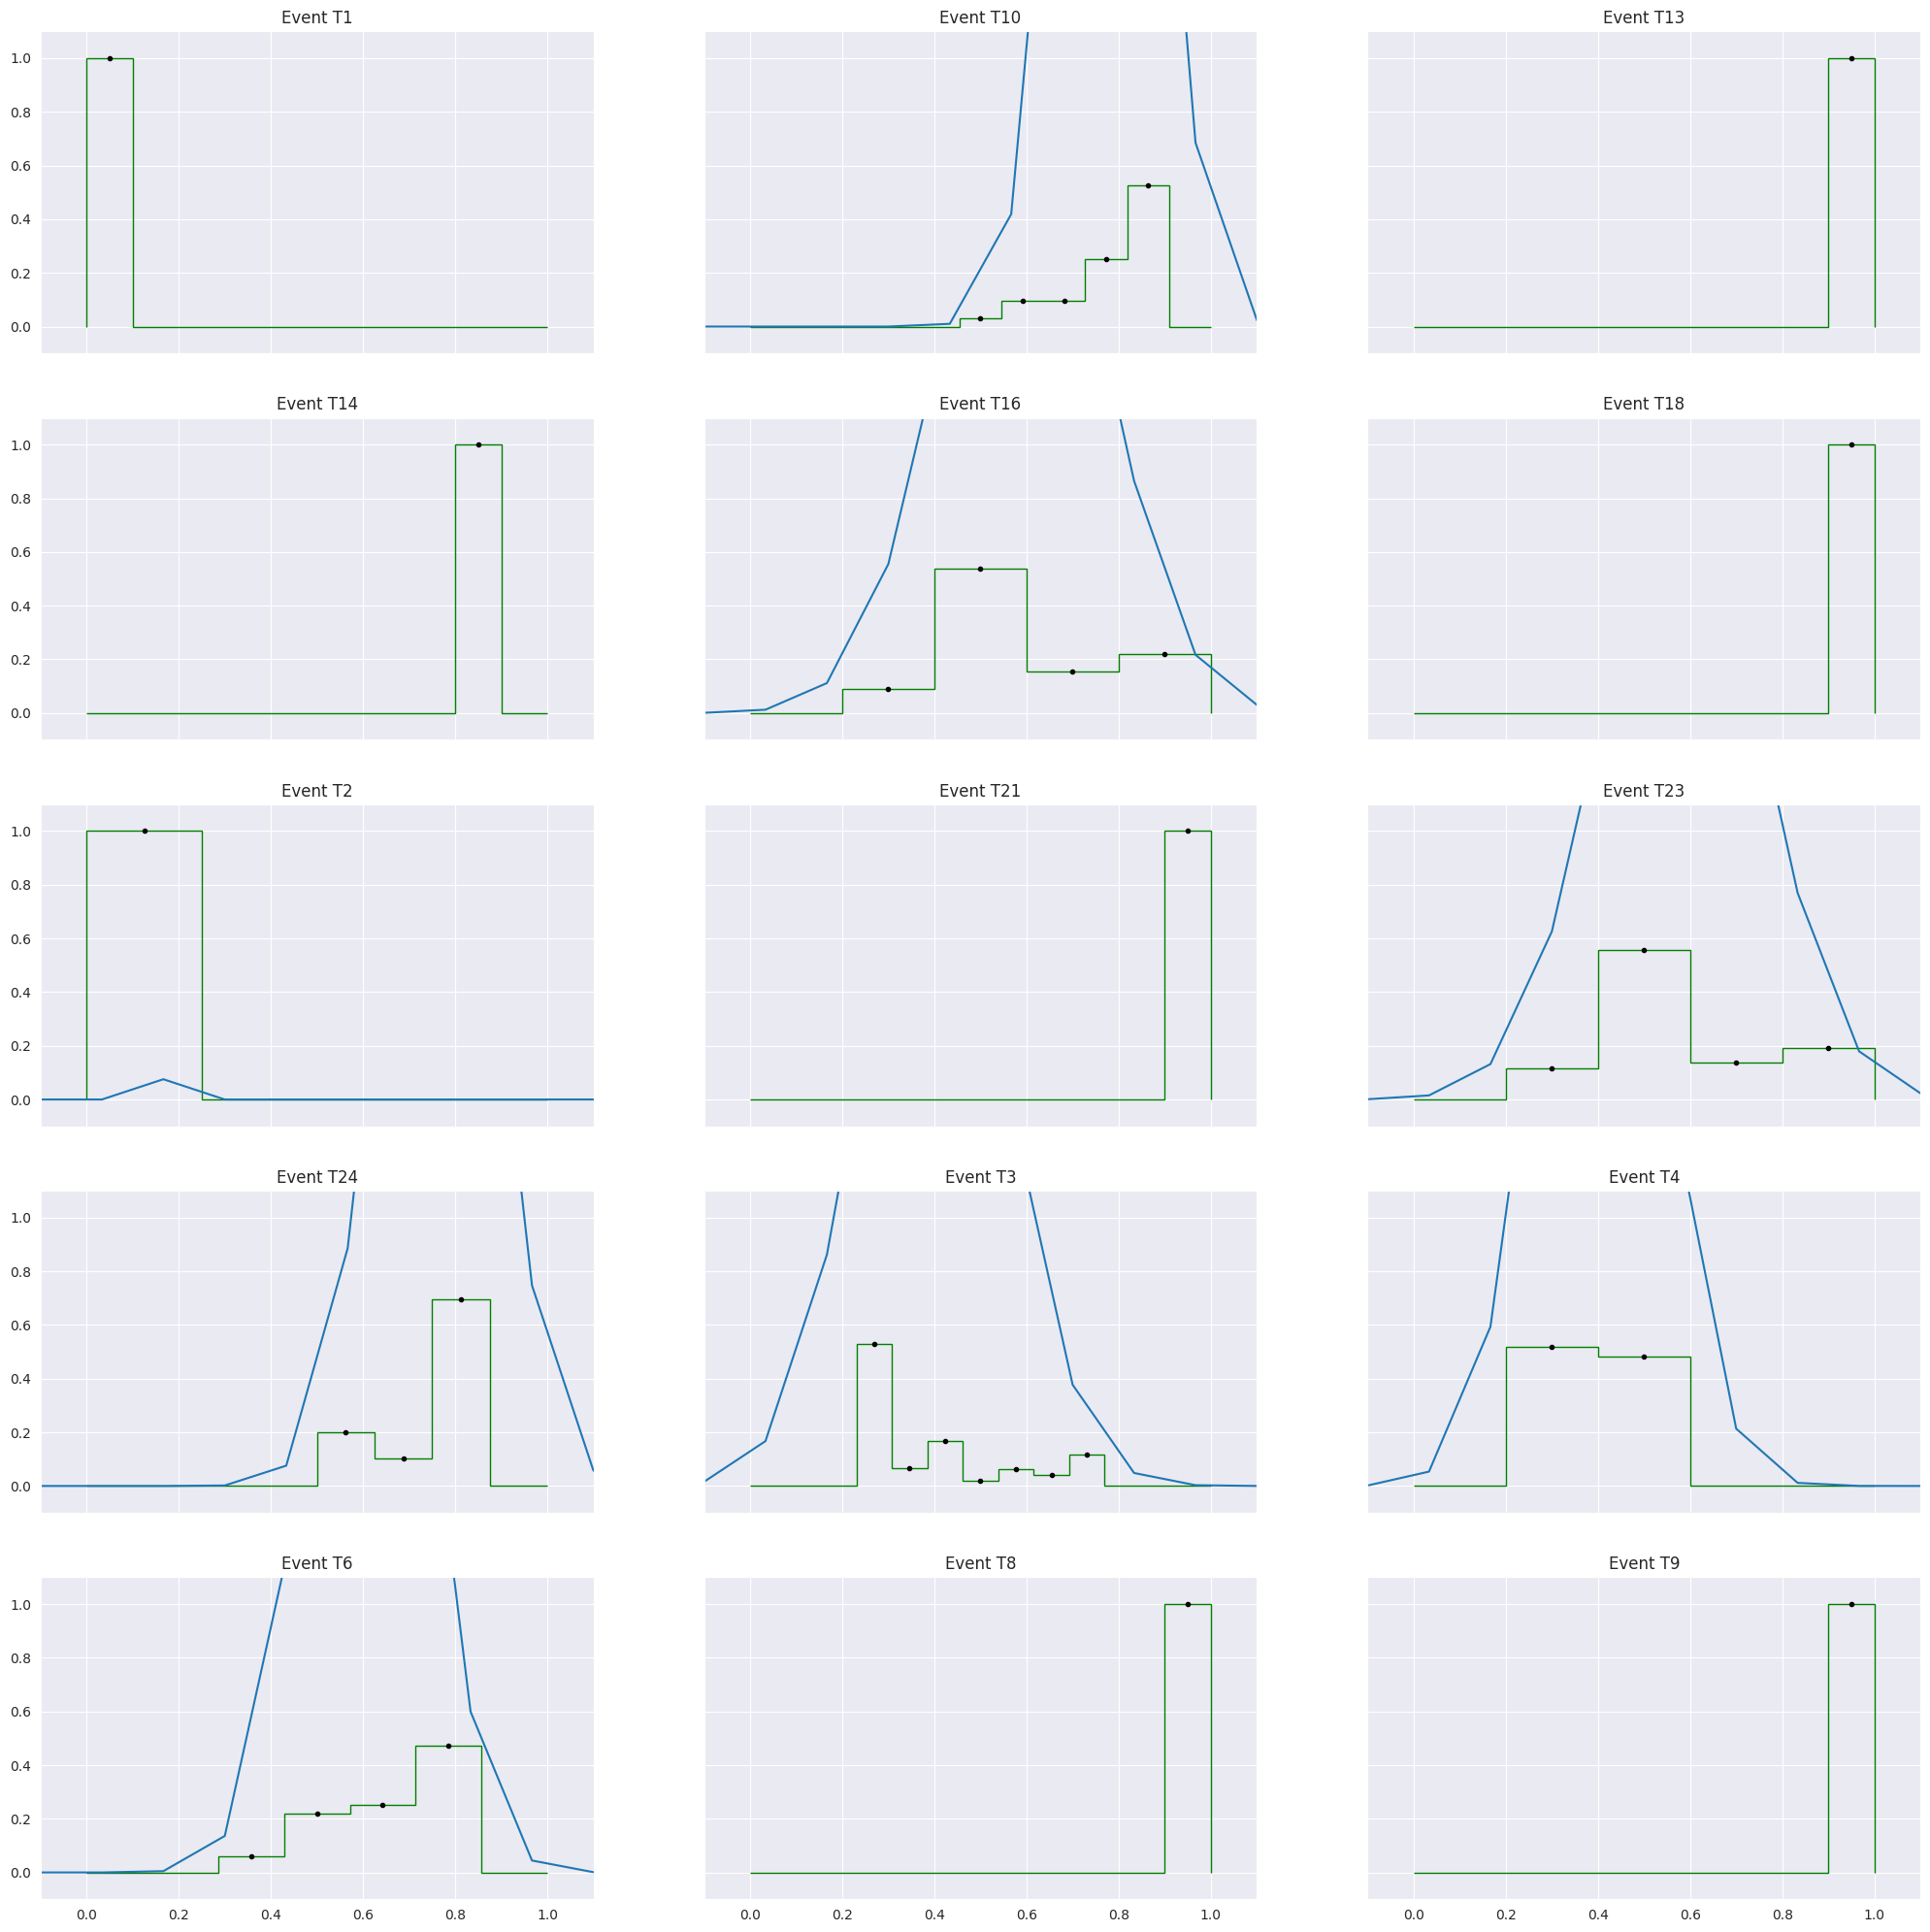

In [125]:
def freedman_diaconis_rule(data):
    """rule to find the bin width and number of bins from data"""
    if (iqr(data)>0):
        bin_width = 2*iqr(data) / len(data)**(1/3)
        Nbins = int(np.ceil((max(data)-min(data))/bin_width))
        return Nbins, bin_width
    else:
        return 10, 1

def plot_error_bar_points(data, ax, n_bins=10, range=(0.0,1.0)):
    counts, bin_edges = np.histogram(data,bins=n_bins,range=range, density=False,weights=np.ones(len(data)) / len(data))
    x = (bin_edges[1:][counts > 0] + bin_edges[:-1][counts > 0]) / 2
    y = counts[counts > 0]
    sy = np.sqrt(counts[counts > 0])*counts[counts > 0]
    ax.errorbar(x,y,yerr=0.0,xerr=0.0,fmt='.k',ecolor='k',elinewidth=1, capsize=1, capthick=1)

def plot_event_hists(events, data):
    no_of_events = len(events)
    no_of_rows = no_of_events // 3
    no_of_cols = 3
    xmin = 0.0
    xmax = 1.0
    remainder = no_of_events % 3
    if remainder>0:
        no_of_rows += 1
    fig, axs = plt.subplots(nrows=no_of_rows,ncols=no_of_cols,figsize=(25, 5*no_of_rows),sharex=True,sharey=True)
    row = 0
    col = 0
    for event in events:
        n_bins, bin_width = freedman_diaconis_rule(data[event]) 
        axs[row,col].hist(data[event],histtype='step',bins=n_bins,range=(xmin, xmax),density=False, weights=np.ones(len(data[event])) / len(data[event]), color='g', cumulative=False)
        axs[row,col].set_title(f'Event {event}')
        axs[row,col].grid(True,axis='both')
        plot_error_bar_points(data[event],axs[row,col],n_bins=n_bins,range=(xmin,xmax))
        mu, sigma = norm.fit(data[event])
        #if sigma==0 position is exactly mu for all data
        if sigma!=0:
            xx = np.linspace(-0.1,1.1,10)
            # yy = norm.cdf(xx,loc=mu,scale=sigma)
            yy = norm.pdf(xx,loc=mu,scale=sigma)
            axs[row,col].plot(xx,yy)
        else:
            print(f'{event} - {mu}')
        
        # update referenced histogram
        if col < no_of_cols-1:
            col += 1
        else:
            col = 0
            row += 1
    plt.setp(axs, xlim=(-0.1,1.1), ylim=(-0.1,1.1))
    plt.show()
        
log_name = 'pdc2022_111000'
events = sorted(hist_for_event.keys())
plot_event_hists(events,hist_for_event)

In [100]:
data_matrix = np.ndarray((len(hist_for_event.keys()),1000))
means = []
i = 0
for k, v in hist_for_event.items():
    fill_pos = len(v)
    mean = np.mean(v)
    for j in range(1000):
        if j < fill_pos:
            data_matrix[i,j] = v[j]
        else:
            data_matrix[i,j] = mean
    means.append(mean)
    i += 1
means==np.mean(data_matrix,axis=1)

array([ True, False,  True, False, False, False,  True,  True,  True,
        True, False,  True,  True,  True,  True])

In [117]:
test_log = pm4py.read_xes('/home/vco/Datasets/PDC22/Test Logs/pdc2022_000000.xes')
test_log = enrich_log(test_log)
base_log = pm4py.read_xes('/home/vco/Datasets/PDC22/Base Logs/pdc2022_000000.xes')
base_log = enrich_log(base_log)
gt_log = pm4py.read_xes('/home/vco/Datasets/PDC22/Ground Truth Logs/pdc2022_000000.xes')
truth_values = gt_log[['case:concept:name','case:pdc:isPos']].drop_duplicates()

parsing log, completed traces :: 100%|██████████| 1000/1000 [00:00<00:00, 16348.68it/s]


In [104]:
from scipy.spatial.distance import mahalanobis

In [122]:
# Single point coordinates
single_point_test = np.array(test_log[test_log['case:concept:name']=='trace 021110 243']['concept:name'])
single_point_base = np.array(base_log[base_log['case:concept:name']=='trace 021110 243']['concept:name'])
single_point_gt = np.array(gt_log[gt_log['case:concept:name']=='trace 021110 243']['concept:name'])

# Mean and covariance matrix of the distribution
distribution_mean = np.mean(data_matrix,axis=1) # Replace with the distribution's mean
covariance_matrix = np.cov(data_matrix) # Replace with the covariance matrix

# Calculate Mahalanobis distance (a generalization of Euclidean distance)
det = np.linalg.det(covariance_matrix)
if det == 0:
    print(f'det {det}')
else:
    inv_covariance_matrix = np.linalg.inv(covariance_matrix)
    distance_test = mahalanobis(single_point_test, distribution_mean, inv_covariance_matrix)
    print("Mahalanobis Distance test:", distance_test)
    distance_base = mahalanobis(single_point_base, distribution_mean, inv_covariance_matrix)
    print("Mahalanobis Distance base:", distance_base)
    distance_gt = mahalanobis(single_point_gt, distribution_mean, inv_covariance_matrix)
    print("Mahalanobis Distance gt:", distance_gt)
    print(f"gt says {'test' if truth_values['trace 021110 243']['case:pdf:isPos'] else 'base'}")

det 0.0


US2: Given a trace I want to see a histogram and a fitted function for each event in a single plot interactively.

In [484]:
norm.pdf(10,loc=mu, scale=sigma)

0.0

(array([1.42829331, 0.92514453, 0.95760574, 0.8439915 , 0.94137513,
        1.07121998, 1.03875877, 1.05498937, 0.97383635, 0.92514453]),
 array([0.00568182, 0.10410354, 0.20252525, 0.30094697, 0.39936869,
        0.4977904 , 0.59621212, 0.69463384, 0.79305556, 0.89147727,
        0.98989899]),
 [<matplotlib.patches.Polygon at 0x7f66d7387c10>])

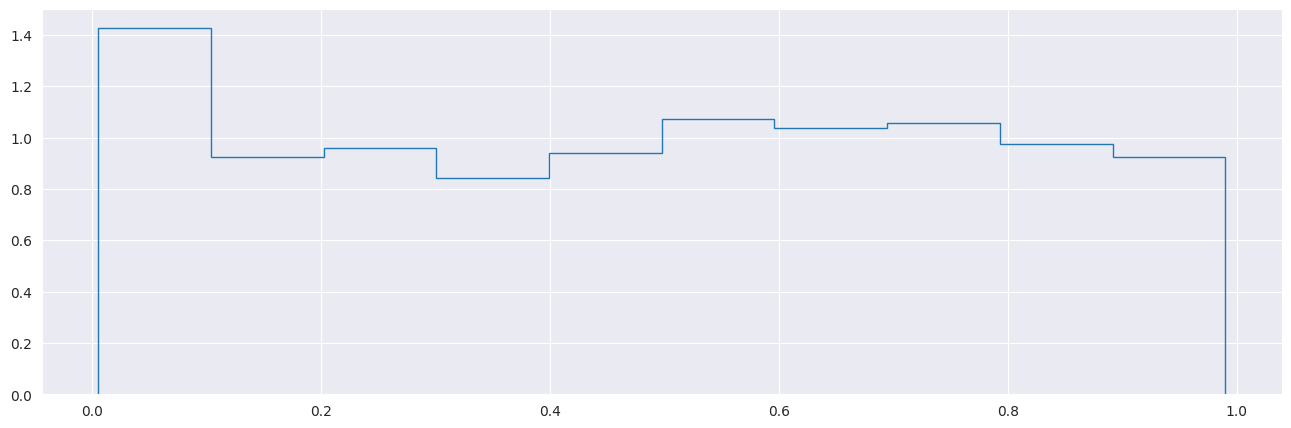

In [275]:
test_pos = logs_hists_for_events['pdc2022_000011.xes'][log_types[1]][event]
fig, ax = plt.subplots(figsize=(16, 5))
test_counts, test_bin_edges = np.histogram(test_pos,range=[0,1],density=True)
ax.hist(test_pos,density=True,bins=nbins,histtype='step')

(array([1.42963712, 1.12096547, 0.90976908, 0.95850671, 1.00724434,
        0.99099846, 1.07222784, 0.95850671, 0.95850671, 0.81229382]),
 array([0.00564972, 0.10350994, 0.20137017, 0.29923039, 0.39709062,
        0.49495084, 0.59281107, 0.69067129, 0.78853152, 0.88639174,
        0.98425197]),
 [<matplotlib.patches.Polygon at 0x7f66ce790cd0>])

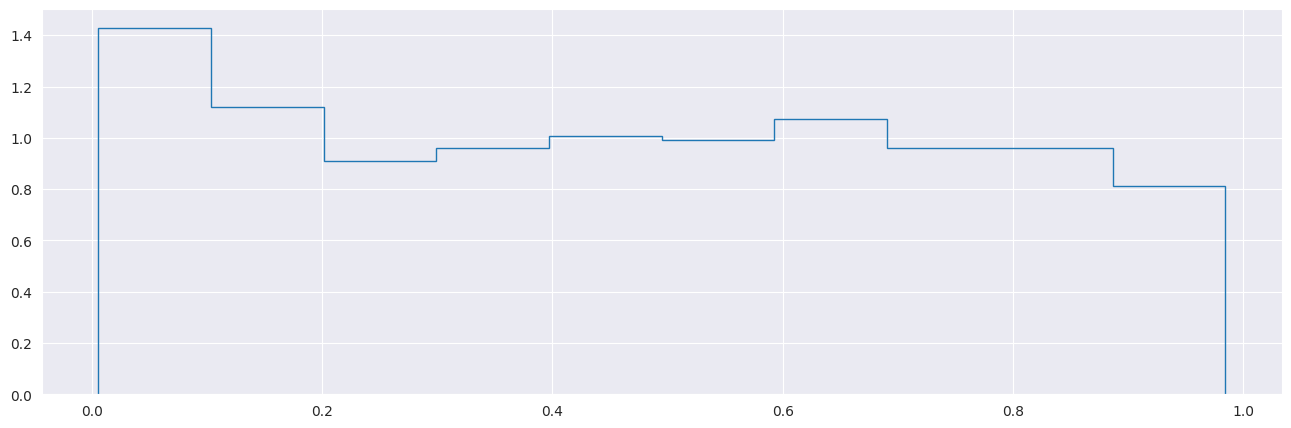

In [276]:
base_pos = logs_hists_for_events['pdc2022_000011.xes'][log_types[2]][event]
fig, ax = plt.subplots(figsize=(16, 5))
base_counts, base_bin_edges = np.histogram(base_pos,range=[0,1],density=True)
ax.hist(base_pos,density=True,bins=nbins,histtype='step')

(array([1.42829331, 0.92514453, 0.95760574, 0.8439915 , 0.94137513,
        1.07121998, 1.03875877, 1.05498937, 0.97383635, 0.92514453]),
 array([0.00568182, 0.10410354, 0.20252525, 0.30094697, 0.39936869,
        0.4977904 , 0.59621212, 0.69463384, 0.79305556, 0.89147727,
        0.98989899]),
 [<matplotlib.patches.Polygon at 0x7f66ce7e8b90>])

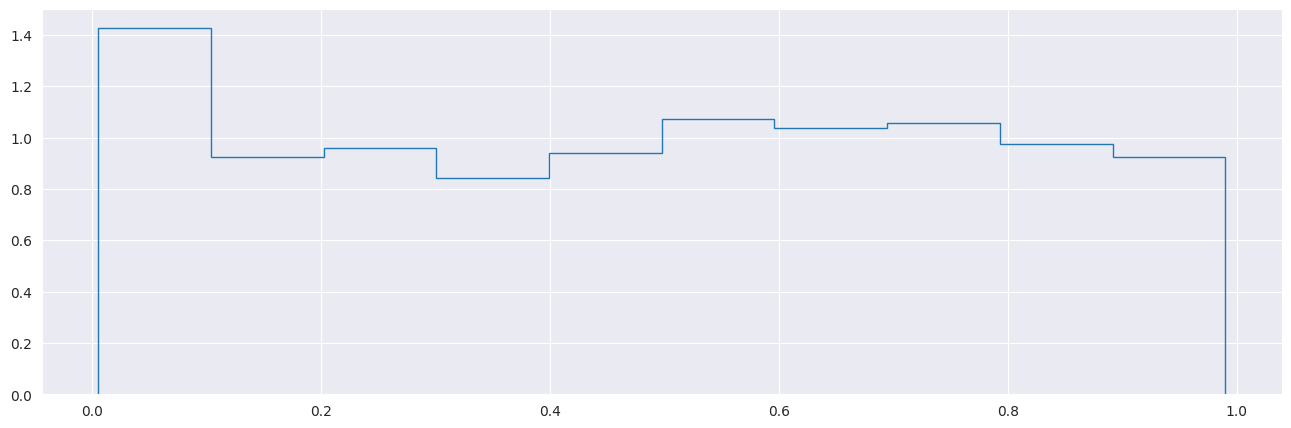

In [277]:
gt_pos = logs_hists_for_events['pdc2022_000011.xes'][log_types[3]][event]
fig, ax = plt.subplots(figsize=(16, 5))
gt_counts, gt_bin_edges = np.histogram(gt_pos,range=[0,1],density=True)
ax.hist(gt_pos,density=True,bins=nbins,histtype='step')

In [278]:
ks_2samp(train_counts,test_counts)

KstestResult(statistic=0.9, pvalue=0.00021650176448938054, statistic_location=0.3554313099041532, statistic_sign=1)

In [279]:
ks_2samp(train_counts,base_counts)

KstestResult(statistic=0.9, pvalue=0.00021650176448938054, statistic_location=0.3554313099041532, statistic_sign=1)

In [280]:
ks_2samp(test_counts,base_counts)

KstestResult(statistic=0.3, pvalue=0.7869297884777761, statistic_location=0.9265175718849842, statistic_sign=1)

In [281]:
ks_2samp(test_counts,gt_counts)

KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0.830670926517572, statistic_sign=1)

In [282]:
ks_2samp(base_counts,gt_counts)

KstestResult(statistic=0.3, pvalue=0.7869297884777761, statistic_location=0.9265175718849842, statistic_sign=-1)

In [244]:
gt_log[['case:concept:name','case:pdc:isPos']].drop_duplicates().groupby('case:pdc:isPos').count()

,case:concept:name
case:pdc:isPos,
False,500
True,500


In [348]:
from scipy.stats import ks_2samp, kstest

In [206]:
x = np.random.normal(0,1,1000)
y = np.random.normal(0,1,1000)

ks_2samp(x, y)

KstestResult(statistic=0.028, pvalue=0.8282194040312439, statistic_location=1.0531950519597828, statistic_sign=1)

# Inferences from manual inspection of trace 0
- T1 is always the first event
- The second event is either T2 or T8
- T14 and T18 are always one after the other and they always occur in the same trace

In [ ]:
# for each histogram normalize the order 0-1
# fit a gaussian function on the training, testing and ground truth
# compare the (training fit against the testing) and (training fit against the base) 
# the one that fits better is the winner

A: Dependent tasks, also known as long-term dependencies. Possible values are 0 for No and 1 for Yes. 
If Yes then all transitions that bypass the dependent tasks are disabled.

B: Loops. Possible values are 0 for No, 1 for Simple, and 2 for Complex. If No, then all transitions 
that start a loop are disabled. If Simple, then all transitions that are a shortcut between the loop 
and the main flow are disabled.

C: OR constructs. Possible values are 0 for No and 1 for Yes. If No, then all transitions that only 
take some inputs for an OR-join and all transitions that generate only some outputs for an OR-split
are disabled.

D: Routing constructs, also known as invisible tasks. Possible values are 0 for No and 1 for Yes. If 
Yes, then some transitions are made invisible.

E: Optional tasks.Possible values are 0 for No and 1 for Yes. If Yes, then some invisible transitions 
are added to allow skipping of some (visible) transitions.

F: Duplicate tasks, also known as recurrent activities. Possible values are 0 for No and 1 for Yes. 
If Yes, then some transitions are relabeled to existing labels.

G: Noise. Possible values are:
   0: no noise,
   1: in every trace with probability 20% either one random event
      is removed (40%), moved (20%), or copied (40%),
   2: in every trace with probability 20% one random event is
      removed,
   3: in every trace with probability 20% one random event is
      moved to a random position, and
   4: in every trace with probability 20% one random event is
      copied to a random position.Logs

In [14]:
def abc_status_to_dict(abc_status):
    long_term_dependencies = True if int(abc_status[0]) == 1 else False
    loops = 'Simple' if int(abc_status[1]) == 1 else 'Complex' if int(abc_status[1]) == 2 else 'No'
    or_constructs = True if int(abc_status[2]) == 1 else False
    invisible_tasks = True if int(abc_status[3]) == 1 else False
    optional_tasks = True if int(abc_status[4]) == 1 else False
    duplicate_tasks = True if int(abc_status[5]) == 1 else False
    noise = ''
    match int(abc_status[6]):
        case 0:
            noise = 'No noise'
        case 1:
            noise = '1/5 - 1 event is (1/3)*[removed (2/5), moved (1/5) or copied (2/5)]'
        case 2:
            noise = '1/5 - 1 event is removed'
        case 3:
            noise = '1/5 - 1 event is moved'
        case 4:
            noise = '1/5 - 1 event is copied'
        case _:
            noise = 'Not a training log.'
    print(f'Log properties: '
          f'Long term dependencies: {long_term_dependencies}'
          f'Loops: {loops}'
          f'Or constructs: {or_constructs}'
          f'Invisible tasks: {invisible_tasks}'
          f'Optional tasks: {optional_tasks}'
          f'Duplicate tasks: {duplicate_tasks}'
          f'Noise: {noise}')